In [202]:
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing.hankel import hankel_preprocessing

### Tratamento de dados

Carregando os dados

In [203]:
# load npz
data = np.load('data/data_bubble.npz')
data

NpzFile 'data/data_bubble.npz' with keys: data

In [204]:
D = data['data']

In [205]:
D.shape

(201, 201, 81, 3)

81 snapshots de dimensão (201, 201). Cada ponto de um snapshot é tridimensional.

[image.py:701 - _normalize_image_array() ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


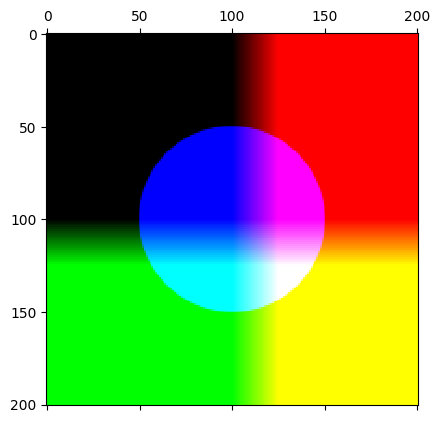

In [206]:
# plotando uma snapshot
plt.matshow(D[:, :, 0])

A parte tridimensional parece ser ruído...

Verificando...

In [207]:
print(D[:, :, 0][0, 0][2], D[:, :, 0][100, 100][2])

0.0 1.0


Mantendo apenas a terceira coluna, binária.

In [208]:
D = D[:, :, :, 2:3]
D.shape

(201, 201, 81, 1)

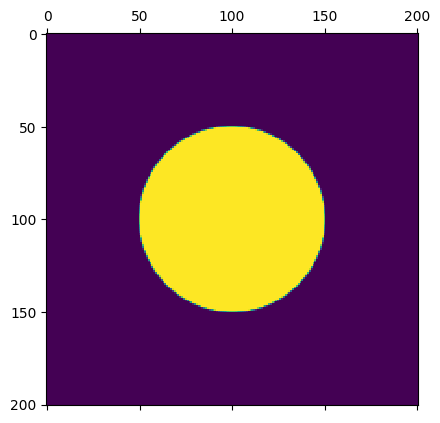

In [209]:
# replotando
plt.matshow(D[:, :, 0])

Mesmo não sendo 100% binário, é o suficiente.

In [264]:
# verificando todos os valores presentes
unique, counts = np.unique(D, return_counts=True)
hashmap = dict(zip(unique, counts))
count_sum = sum(counts)
print('Quantidade de valores únicos: ', len(unique))
print('Quantidade de 0s: ', hashmap[0])
print('Quantidade de 1s: ', hashmap[1])
print(f'Valores binários formam cerca de {(hashmap[0]+hashmap[1])/(count_sum)*100:.2f}% da matriz')

Quantidade de valores únicos:  85280
Quantidade de 0s:  2303603
Quantidade de 1s:  350879
Valores binários formam cerca de 81.12% da matriz


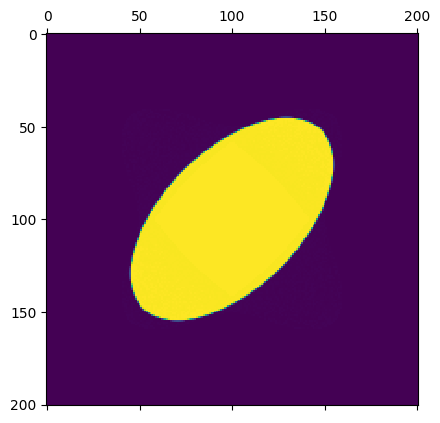

In [210]:
plt.matshow(D[:, :, 50])

Simplificando...

In [211]:
D = np.squeeze(D)
D.shape

(201, 201, 81)

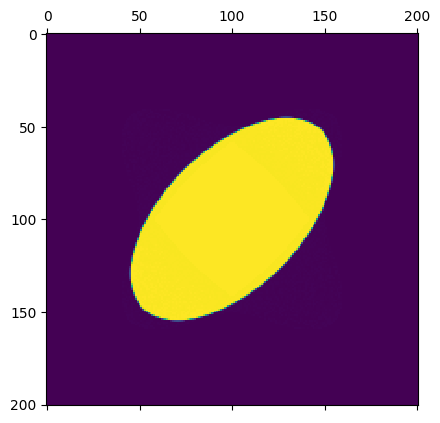

In [212]:
plt.matshow(D[:, :, 50])

Tudo certo! Partimos daqui.

### Plots

In [213]:
D.shape

(201, 201, 81)

### DMD

In [214]:
D.shape

(201, 201, 81)

In [215]:
# reshape para 2D
D_rs = D.reshape(201*201, 81)
D_rs.shape

(40401, 81)

In [216]:
# exact DMD from pydmd
# acredito que calcular o rank aqui seja desnecessário, mas vai
dmd = DMD(sorted_eigs='real', opt=True)

In [217]:
dmd.fit(D_rs.T)

f:\Documentos\Unesp\TCC\data-driven-dynamics\env\Lib\site-packages\pydmd\plotter.py:673: RuntimeWarning: invalid value encountered in log
  eigs = np.log(lead_eigs)


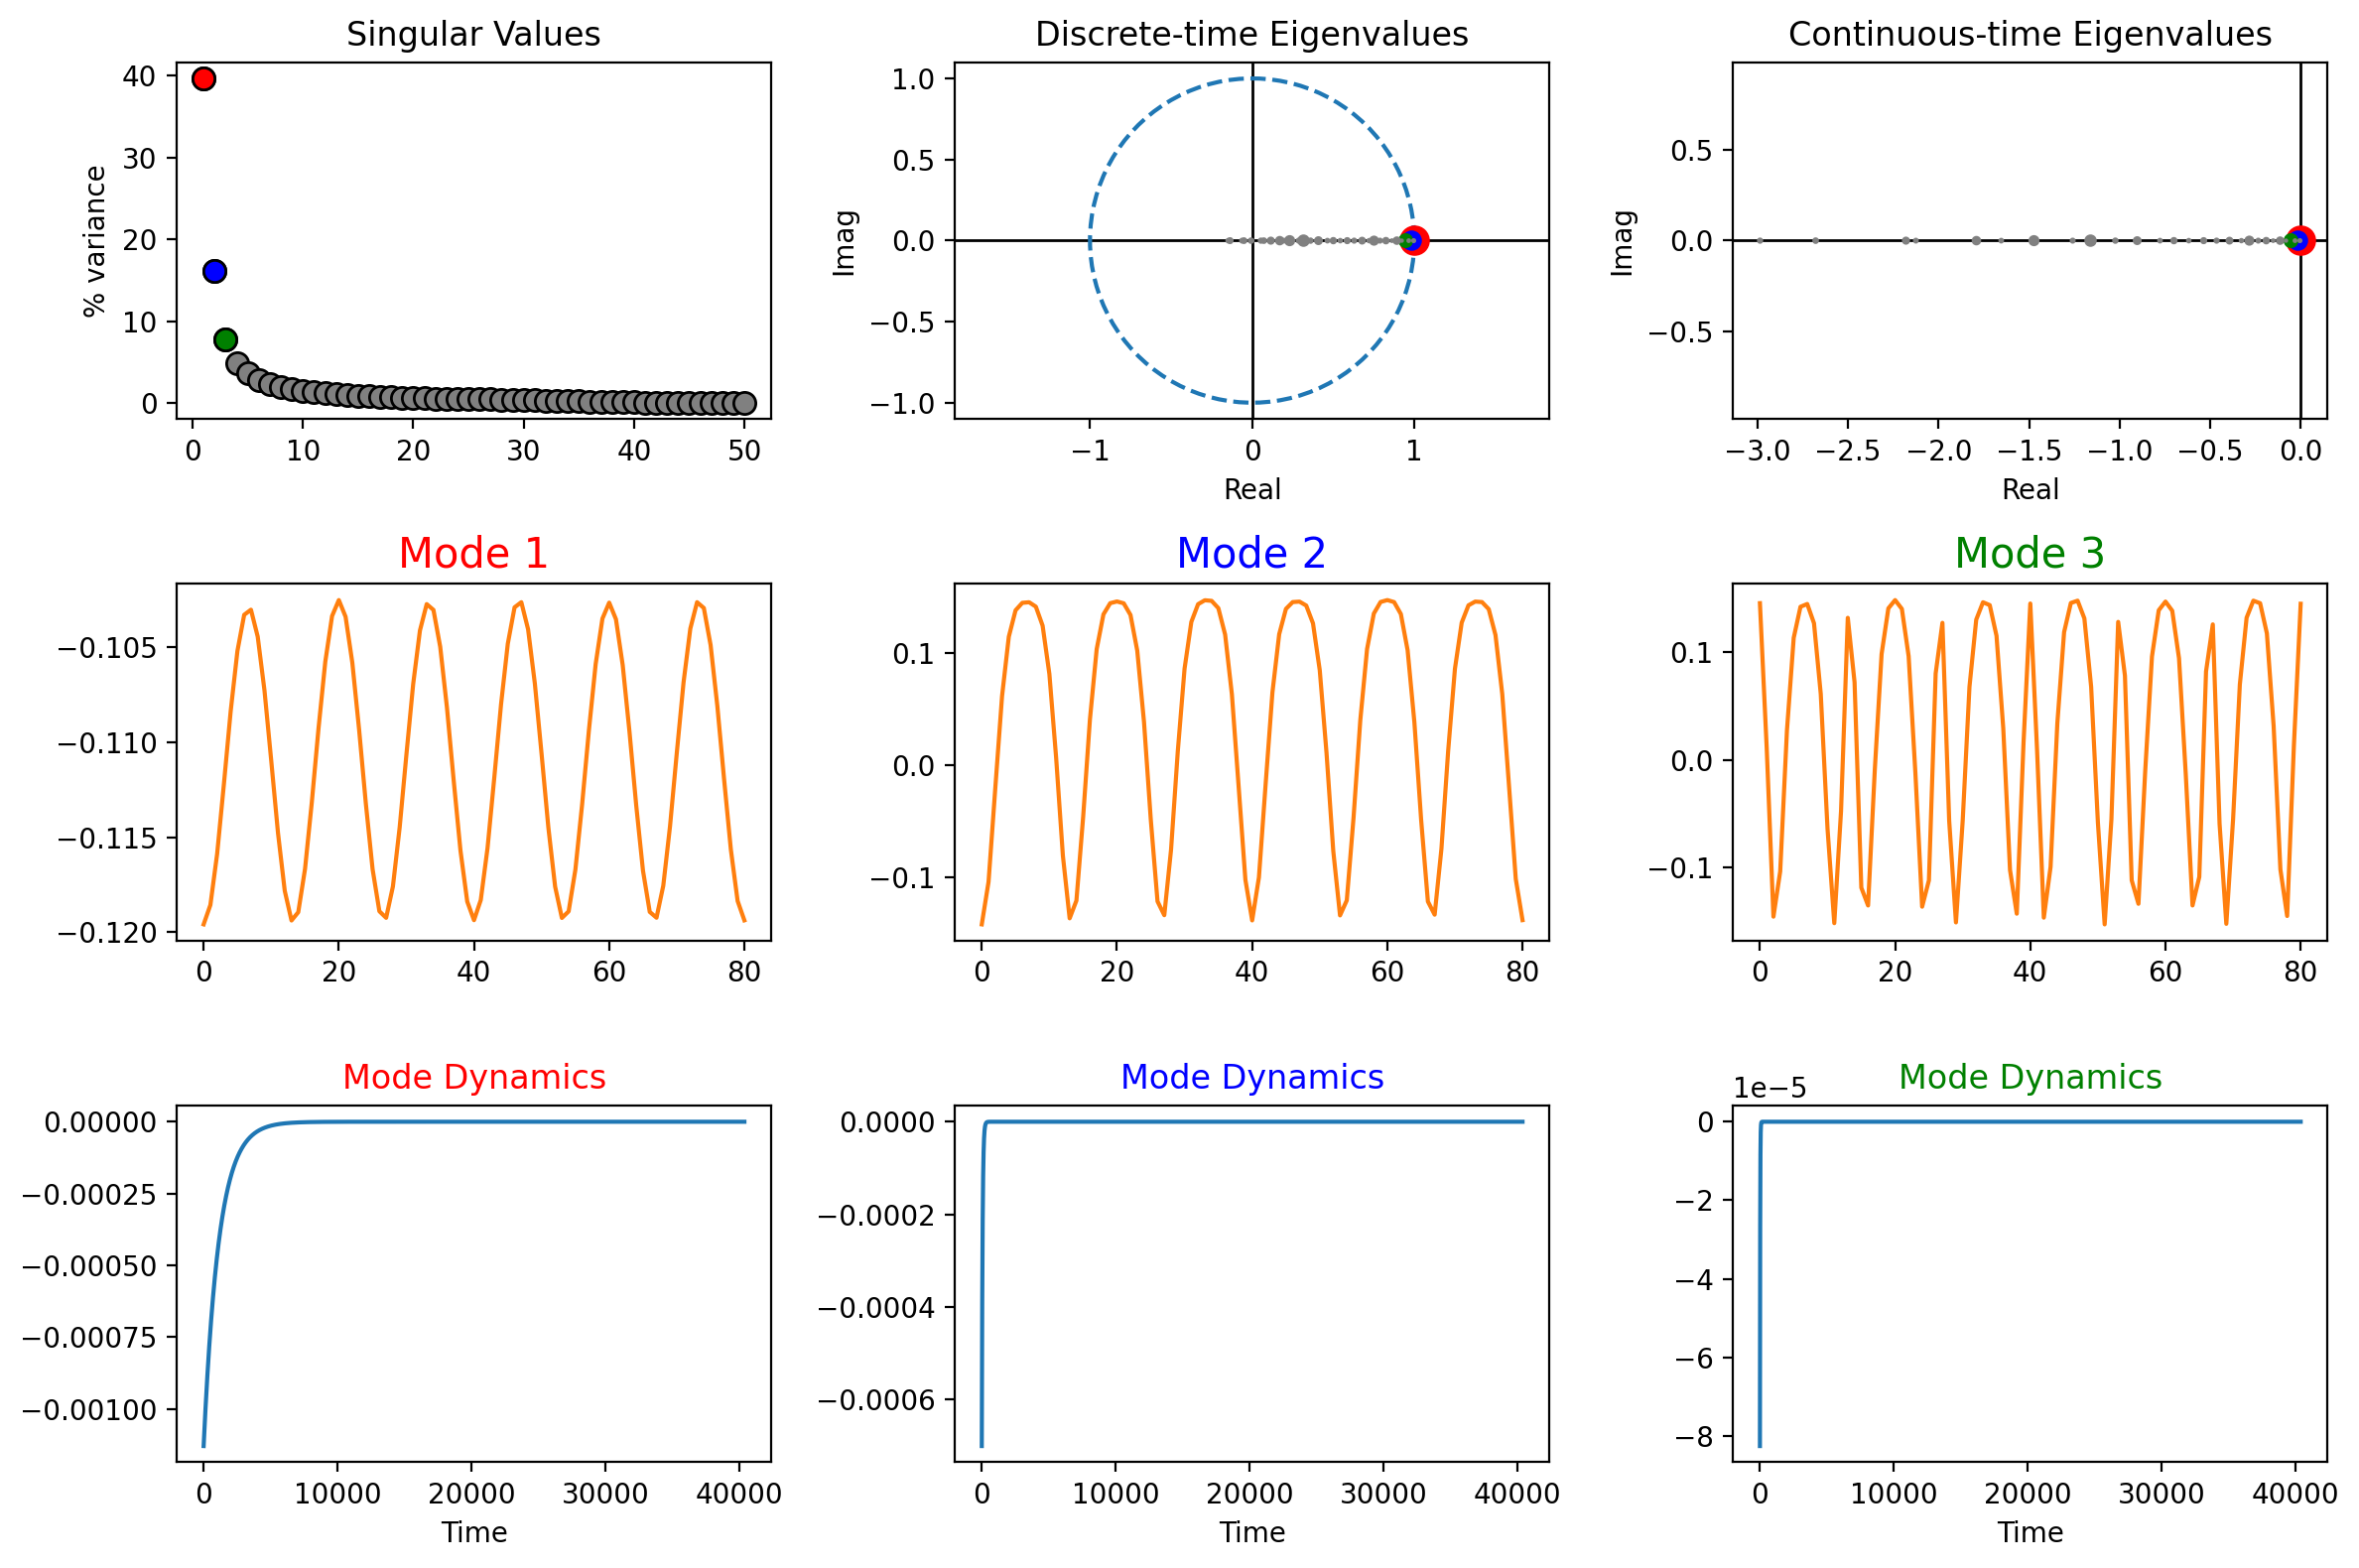

In [218]:
plot_summary(dmd)

In [219]:
# number of modes found
dmd.modes.shape

(81, 36)

In [220]:
dmd.modes.shape

(81, 36)

In [221]:
# reconstructing with only two first modes
modes = dmd.modes.T
modes.shape

(36, 81)

In [222]:
modes[0].shape

(81,)

In [223]:
modes = list(modes)
modes.reverse()

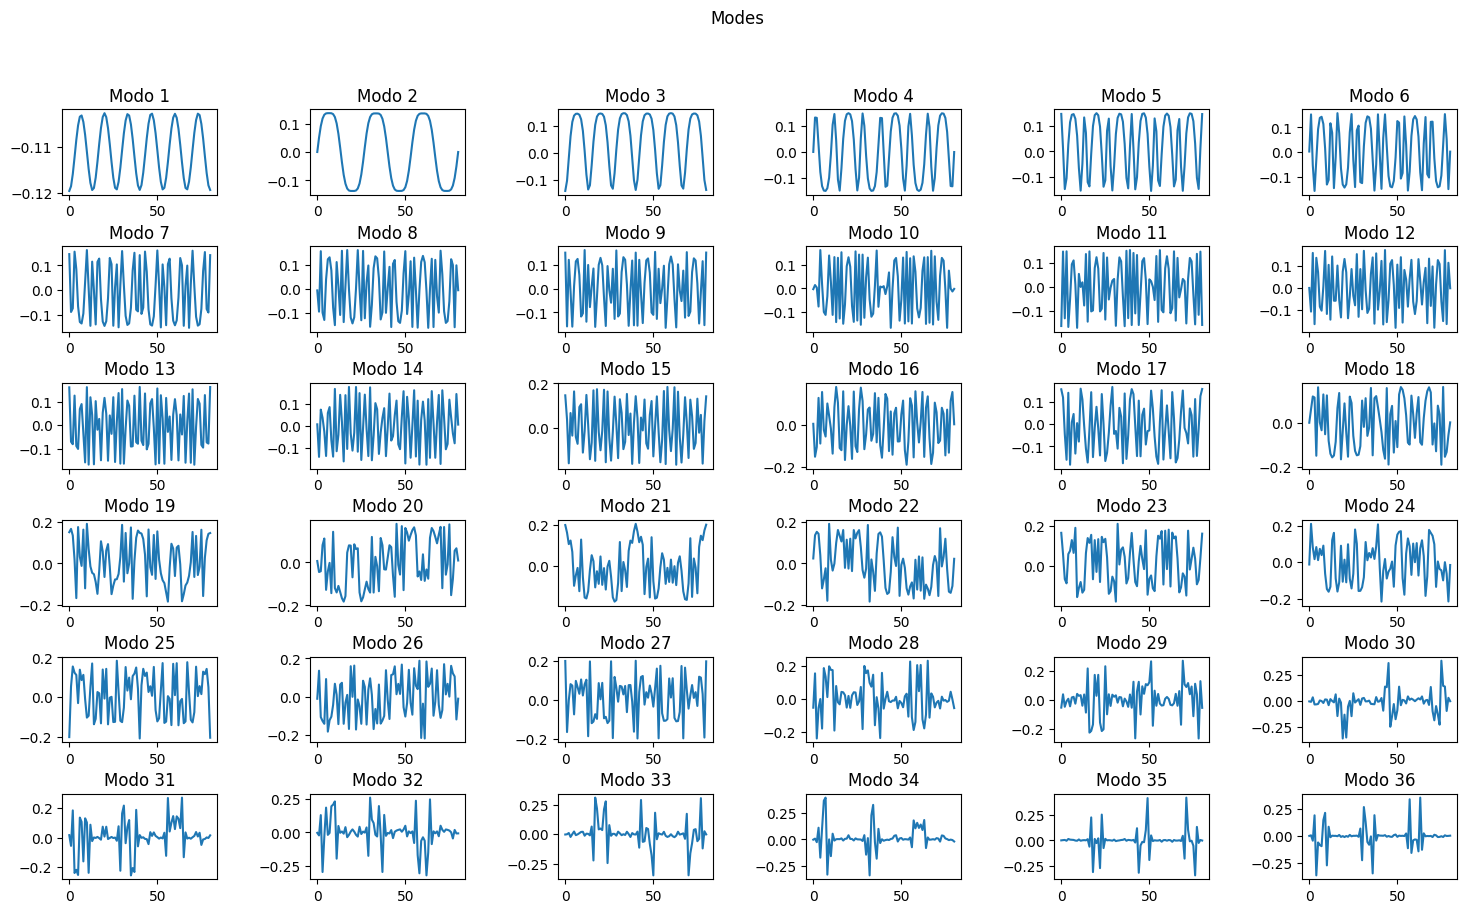

In [224]:
# plot each one against an artificially generated x 0..80
x = np.arange(0, 81, 1)
fig, ax = plt.subplots(6 ,6) # there are 36 modes
# set figure size
fig.set_size_inches(18, 10)
# increase space between subplots
fig.subplots_adjust(hspace=0.6, wspace=0.6)
fig.suptitle('Modes')
#for j in range(6):
#    for i in range(6):
#        ax[i, j].plot(x, modes[i*6 + j])
#        ax[i, j].set_title(f'Modo {i*6 + j + 1}')
i = 0
j = 0
for mode in modes:
    ax[i, j].plot(x, mode)
    ax[i, j].set_title(f'Modo {i*6 + j + 1}')
    j += 1
    if j == 6:
        j = 0
        i += 1

In [225]:
dmd.modes.shape

(81, 36)

### DMD manual

In [226]:
rank = 36

In [227]:
D_rs.shape

(40401, 81)

In [228]:
X = D_rs[:, :-1]
Y = D_rs[:, 1:]

In [229]:
print(X.shape, Y.shape)

(40401, 80) (40401, 80)


In [230]:
U, s, V = np.linalg.svd(X, full_matrices=False)
V = V.conj().T
U = U[:, :rank]
V = V[:, :rank]
s = s[:rank]

In [231]:
atilde = np.linalg.multi_dot([U.T.conj(), Y, V]) * np.reciprocal(s)
atilde.shape

(36, 36)

In [245]:
# test: actually computing A = X' V S^-1 U^T
A = np.linalg.multi_dot([Y, V, np.diag(np.reciprocal(s)), U.T.conj()])

In [236]:
Lambda, W = np.linalg.eig(atilde)
print(Lambda.shape, W.shape)

(36,) (36, 36)


In [238]:
#Phi = U.dot(W)
Phi = np.linalg.multi_dot([Y, V, np.diag(np.reciprocal(s)), W])
Phi.shape

(40401, 36)

In [250]:
phi_teste = Phi.T.reshape(36, 201, 201)
phi_teste.shape

(36, 201, 201)

In [239]:
b = np.linalg.lstsq(Phi, X.T[0], rcond=None)[0]
b.shape

(36,)

In [240]:
# Vetor omega
omega = np.log(Lambda)
omega

array([ 1.47161929e-06+0.j        , -3.22875427e-02+0.j        ,
       -3.68321962e-02+0.00631491j, -3.68321962e-02-0.00631491j,
       -1.24088361e-01+0.j        , -1.49742901e-01+0.01827899j,
       -1.49742901e-01-0.01827899j, -2.83383886e-01+0.j        ,
       -3.50115239e-01+0.03609677j, -3.50115239e-01-0.03609677j,
       -2.02642473e-02+3.14159265j, -3.01731788e-02+3.14159265j,
       -4.79763868e-02+3.14159265j, -8.09845802e-02+3.14159265j,
       -1.15066870e-01+3.14159265j, -1.92385534e-01+3.12154085j,
       -1.92385534e-01-3.12154085j, -2.73017641e-01+3.14159265j,
       -4.17050078e-01+3.11923128j, -4.17050078e-01-3.11923128j,
       -5.47447100e-01+3.14159265j, -6.94209277e-01+3.14159265j,
       -8.72928467e-01+3.14159265j, -1.07359566e+00+3.14159265j,
       -1.21955150e+00+3.14159265j, -5.35981936e-01+0.j        ,
       -7.16300016e-01+0.0291502j , -7.16300016e-01-0.0291502j ,
       -9.51857405e-01+0.j        , -1.23356969e+00+0.j        ,
       -1.52909568e+00+0.

In [241]:
# Matriz T_omega
T_omega = np.zeros((rank, 81), dtype=np.complex_)
for i in range(rank):
    for j in range(81):
        T_omega[i, j] = omega[i]**j
T_omega.shape

(36, 81)

In [242]:
X_dmd = Phi @ np.diag(b) @ T_omega
X_dmd.shape

(40401, 81)

In [243]:
# plotando a reconstrução
X_dmd[:, 0].shape

(40401,)

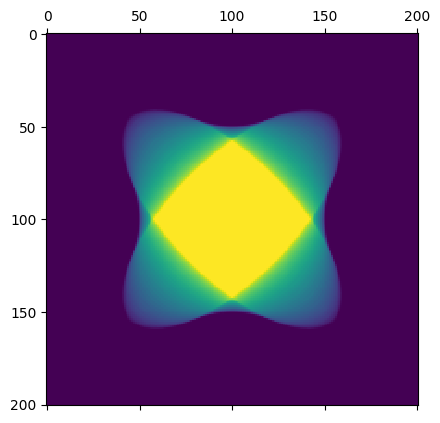

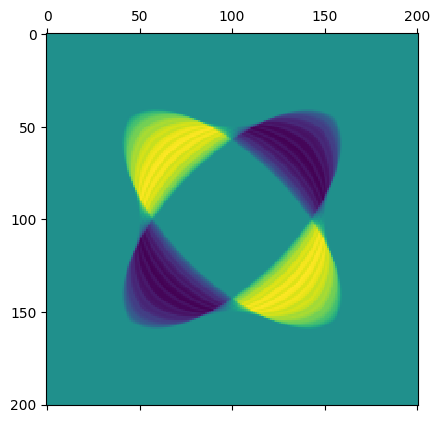

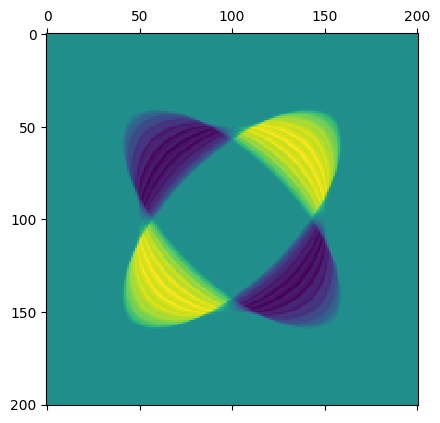

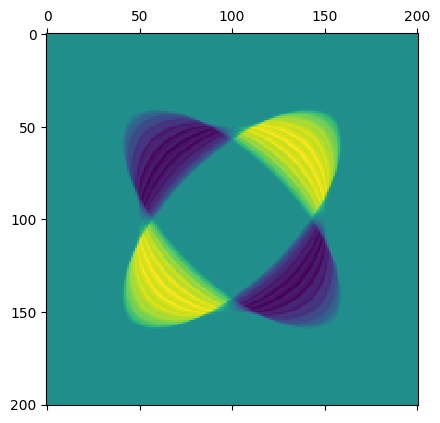

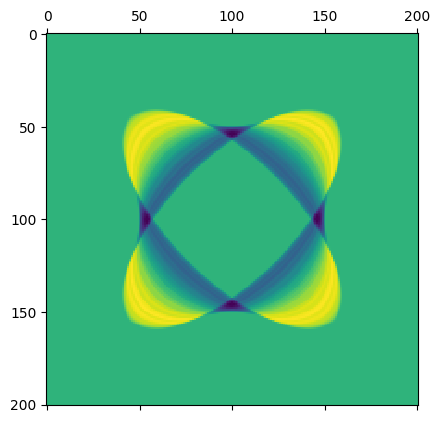

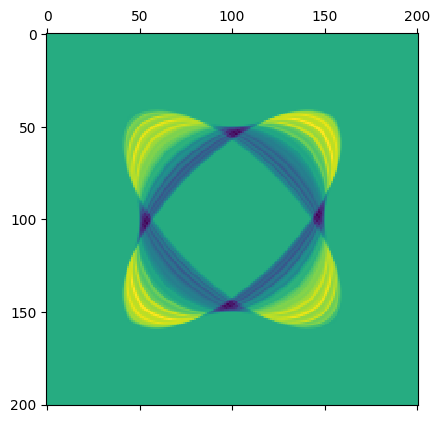

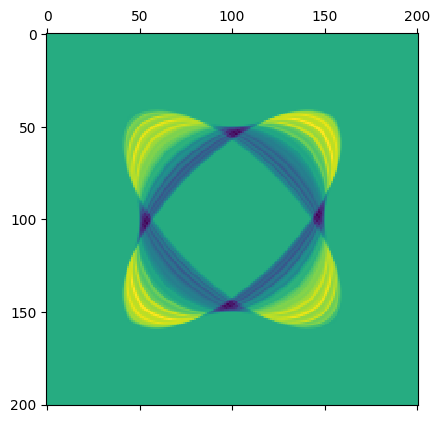

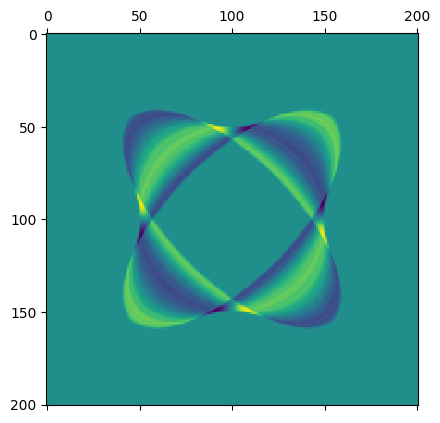

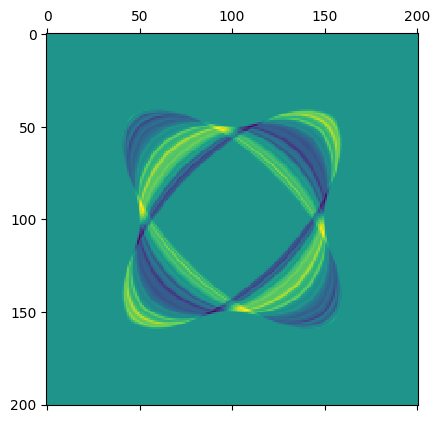

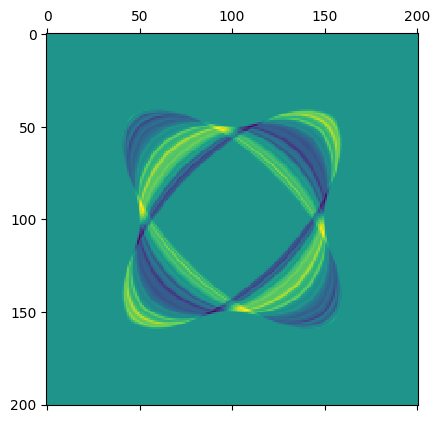

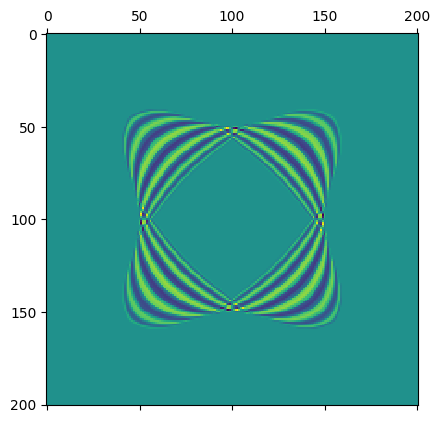

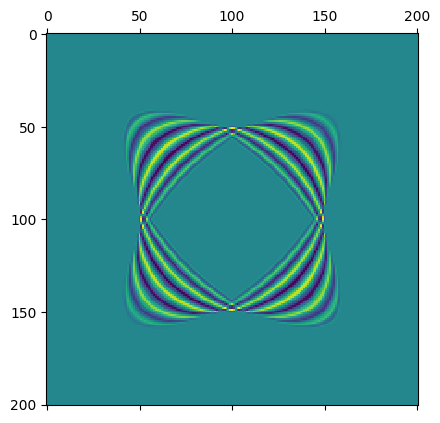

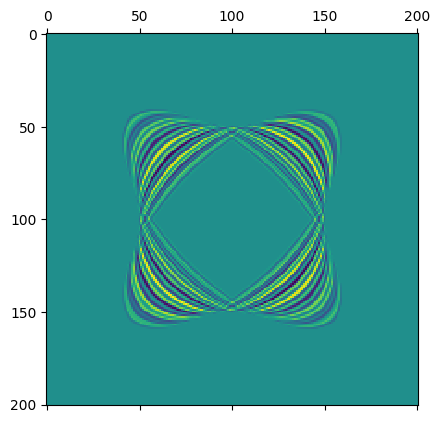

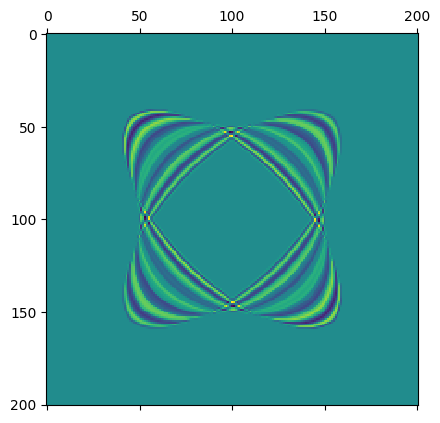

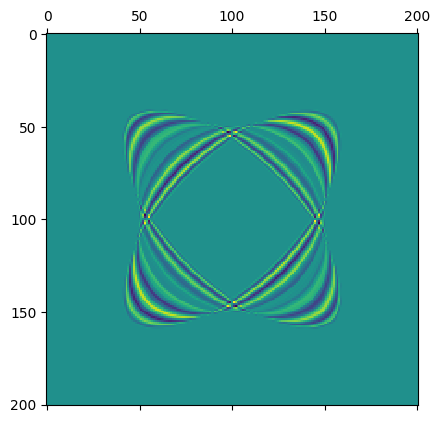

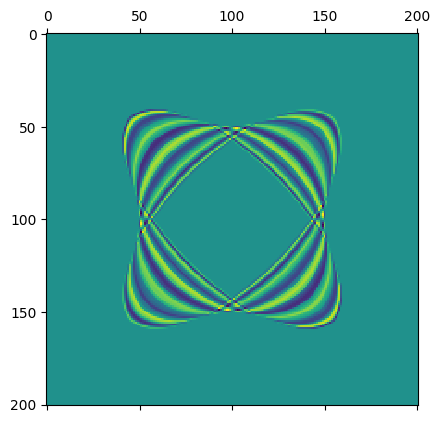

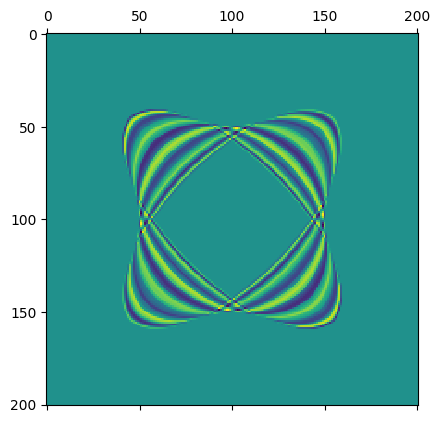

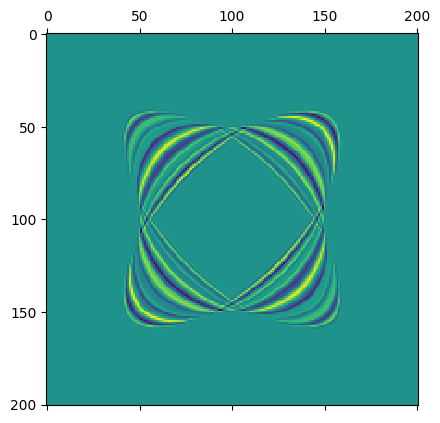

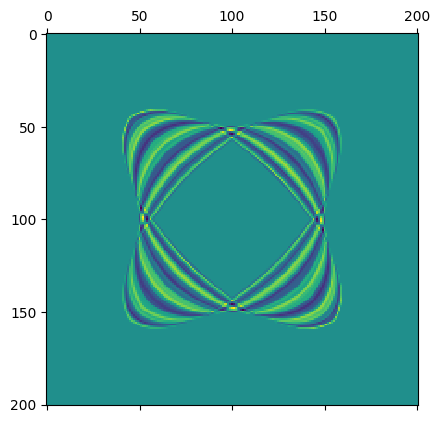

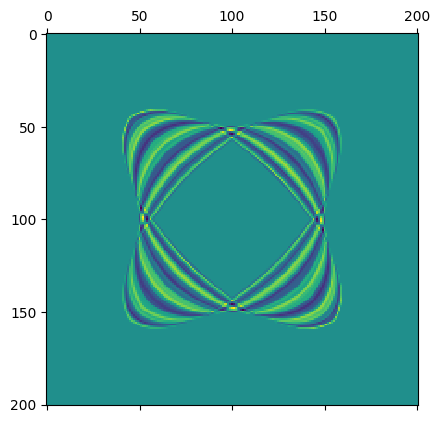

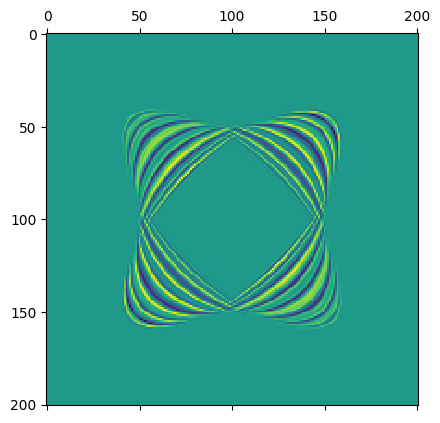

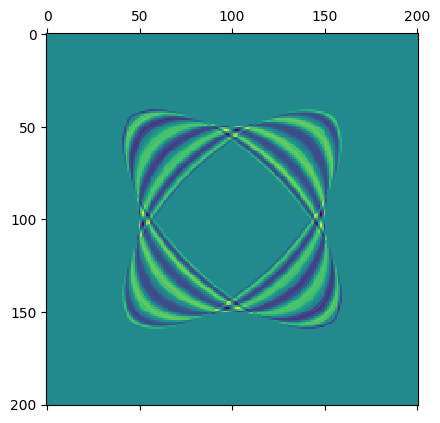

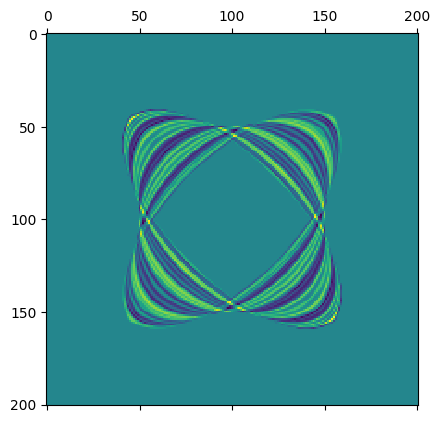

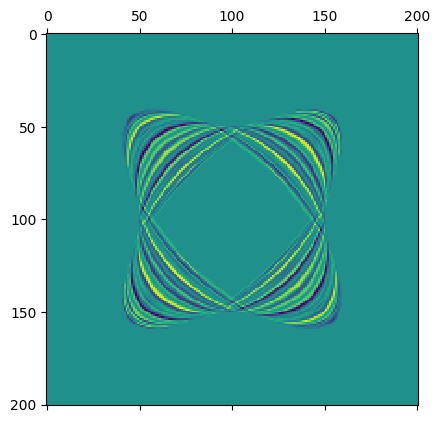

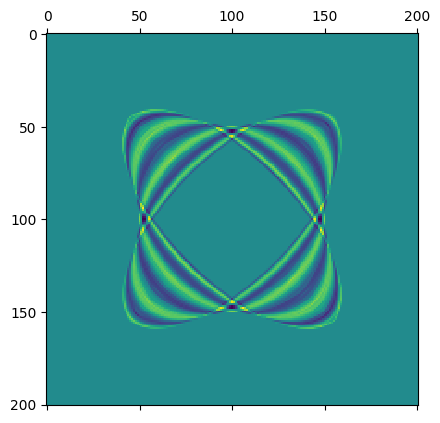

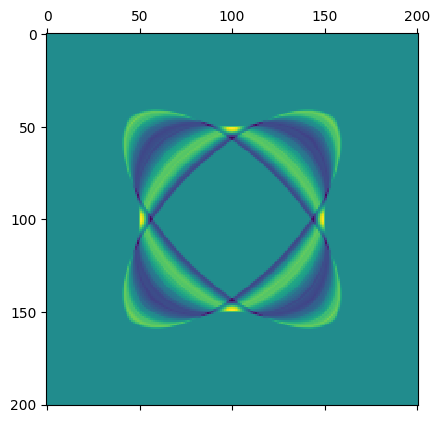

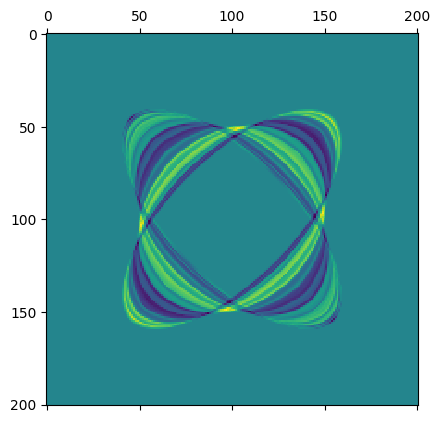

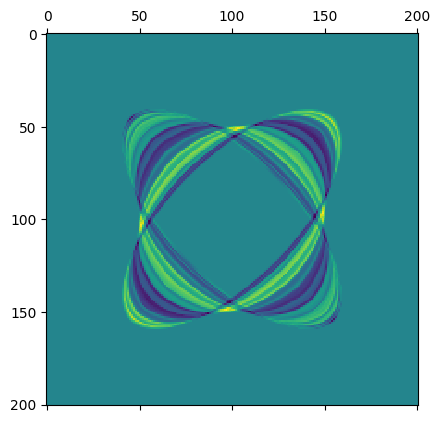

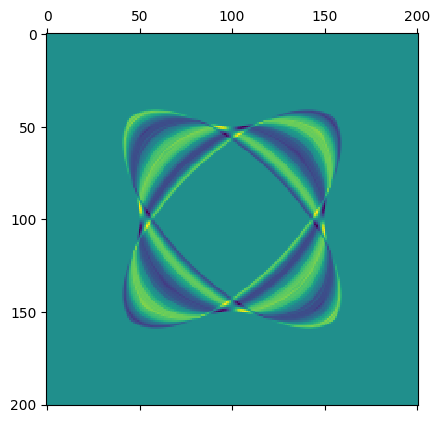

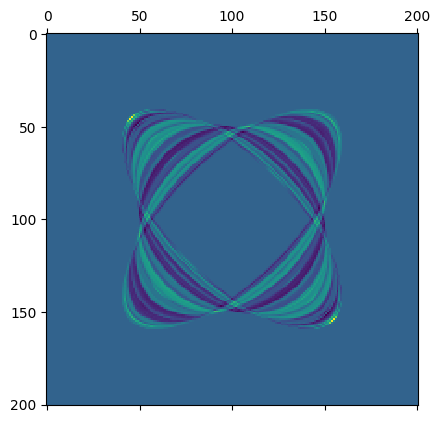

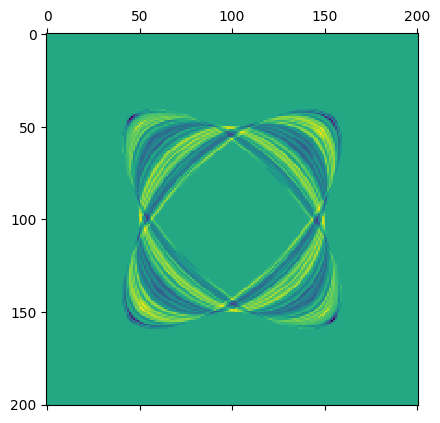

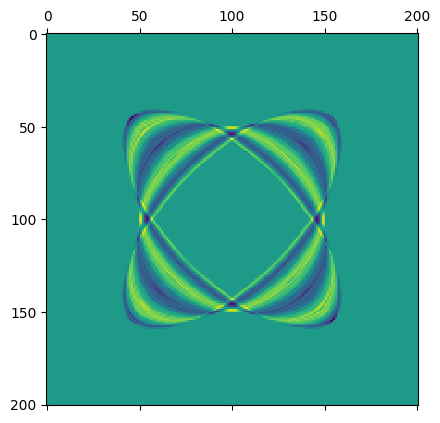

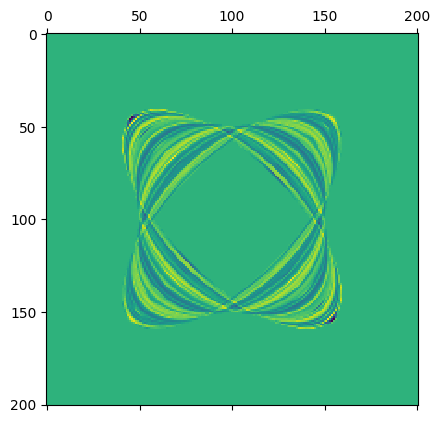

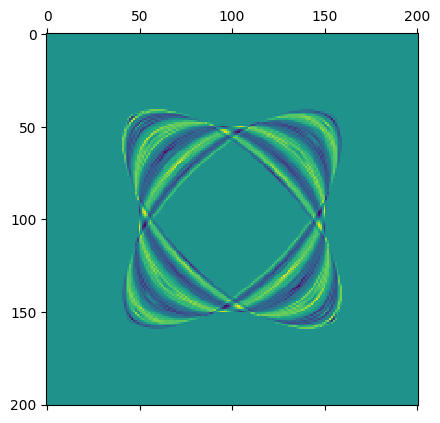

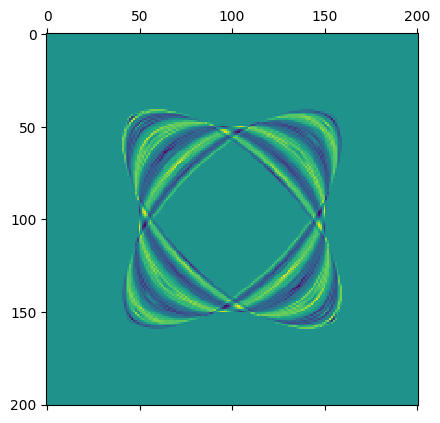

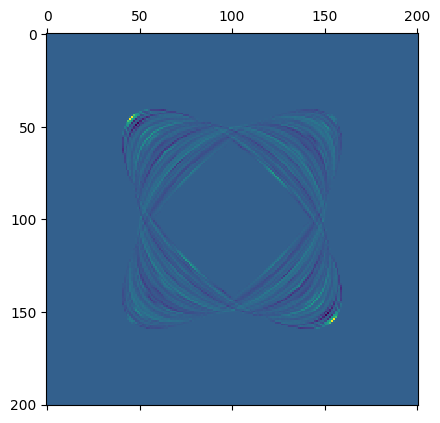

In [254]:
for idx in range(rank):
    mode = phi_teste[idx].real
    plt.matshow(mode)